Problem Statement: The task is to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

MULTINOMIAL CLASSIFICATION (normal or DOS or PROBE or R2L or U2R)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import seaborn as sns
# import statsmodels.formula.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn import datasets
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


In [ ]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20.0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15.0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19.0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21.0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21.0


In [ ]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36148 entries, 0 to 36147
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     36148 non-null  int64  
 1   protocol_type                36148 non-null  object 
 2   service                      36148 non-null  object 
 3   flag                         36148 non-null  object 
 4   src_bytes                    36148 non-null  int64  
 5   dst_bytes                    36148 non-null  int64  
 6   land                         36148 non-null  int64  
 7   wrong_fragment               36148 non-null  int64  
 8   urgent                       36148 non-null  int64  
 9   hot                          36148 non-null  int64  
 10  num_failed_logins            36148 non-null  int64  
 11  logged_in                    36148 non-null  int64  
 12  num_compromised              36148 non-null  int64  
 13  root_shell      

In [ ]:
print("PROTOCOL TYPES", train["protocol_type"].unique(), "\n")
print("SERVICE TYPES", train["service"].unique(), "\n")
print("FLAG TYPES", train["flag"].unique(), "\n")

PROTOCOL TYPES ['tcp' 'udp' 'icmp'] 

SERVICE TYPES ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol'] 

FLAG TYPES ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH'] 



In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,36148.0,301.471257,2.668354e+03,0.0,0.00,0.00,0.00,42862.0
src_bytes,36148.0,19166.405804,2.014772e+06,0.0,0.00,44.00,277.00,381709090.0
dst_bytes,36148.0,3351.762615,8.413152e+04,0.0,0.00,0.00,534.00,5153771.0
land,36148.0,0.000083,9.109750e-03,0.0,0.00,0.00,0.00,1.0
wrong_fragment,36148.0,0.022851,2.552530e-01,0.0,0.00,0.00,0.00,3.0
urgent,36148.0,0.000111,1.663237e-02,0.0,0.00,0.00,0.00,3.0
hot,36148.0,0.205986,2.192422e+00,0.0,0.00,0.00,0.00,77.0
num_failed_logins,36148.0,0.001190,4.492345e-02,0.0,0.00,0.00,0.00,4.0
logged_in,36148.0,0.394683,4.887893e-01,0.0,0.00,0.00,1.00,1.0
num_compromised,36148.0,0.213207,1.048401e+01,0.0,0.00,0.00,0.00,884.0


In [ ]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', ' num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'last_flag'],
      dtype='object')

In [ ]:
import numpy as np

# Assign attack_class values
train.loc[train.attack == 'normal', 'attack_class'] = 0

train.loc[(train.attack.isin(['back', 'land', 'pod', 'neptune', 'smurf', 'teardrop', 'apache2',
                              'udpstorm', 'processtable', 'worm', 'mailbomb'])), 'attack_class'] = 1

train.loc[(train.attack.isin(['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint'])), 'attack_class'] = 2

train.loc[(train.attack.isin(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                              'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack',
                              'httptunnel', 'sendmail', 'named'])), 'attack_class'] = 3

train.loc[(train.attack.isin(['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack',
                              'xterm', 'ps'])), 'attack_class'] = 4

# Convert to integer type, handling NaNs
train['attack_class'] = train['attack_class'].fillna(-1).astype(int)
train.loc[train['attack_class'] == -1, 'attack_class'] = np.nan  # convert back NaNs



In [ ]:
#Adding classification label in testing samples
test.loc[test.attack=='normal','attack_class']=0

test.loc[(test.attack=='back') | (test.attack=='land') | (test.attack=='pod') | (test.attack=='neptune') |
         (test.attack=='smurf') | (test.attack=='teardrop') | (test.attack=='apache2') | (test.attack=='udpstorm') |
         (test.attack=='processtable') | (test.attack=='worm') | (test.attack=='mailbomb'),'attack_class']=1 # 1 = DOS

test.loc[(test.attack=='satan') | (test.attack=='ipsweep') | (test.attack=='nmap') | (test.attack=='portsweep') |
          (test.attack=='mscan') | (test.attack=='saint'),'attack_class']=2  # 2 = PROBE

test.loc[(test.attack=='guess_passwd') | (test.attack=='ftp_write') | (test.attack=='imap') | (test.attack=='phf') |
          (test.attack=='multihop') | (test.attack=='warezmaster') | (test.attack=='warezclient') | (test.attack=='spy') |
          (test.attack=='xlock') | (test.attack=='xsnoop') | (test.attack=='snmpguess') | (test.attack=='snmpgetattack') |
          (test.attack=='httptunnel') | (test.attack=='sendmail') | (test.attack=='named'),'attack_class']=3  # 3 = R2L

test.loc[(test.attack=='buffer_overflow') | (test.attack=='loadmodule') | (test.attack=='rootkit') | (test.attack=='perl') |
          (test.attack=='sqlattack') | (test.attack=='xterm') | (test.attack=='ps'),'attack_class']=4  # 4 = U2L

test["attack_class"] = test["attack_class"].astype(int)

In [ ]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (36148, 44)
Test shape: (22544, 44)


BASIC EXPLORATORY DATA ANALYSIS

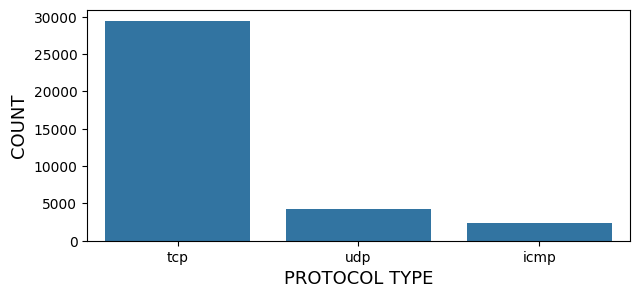

In [ ]:
# Protocol type distribution
plt.figure(figsize=(7,3))
sns.countplot(x="protocol_type", data=train)
plt.xlabel("PROTOCOL TYPE", fontsize=13)
plt.ylabel("COUNT", fontsize=13)
plt.show()

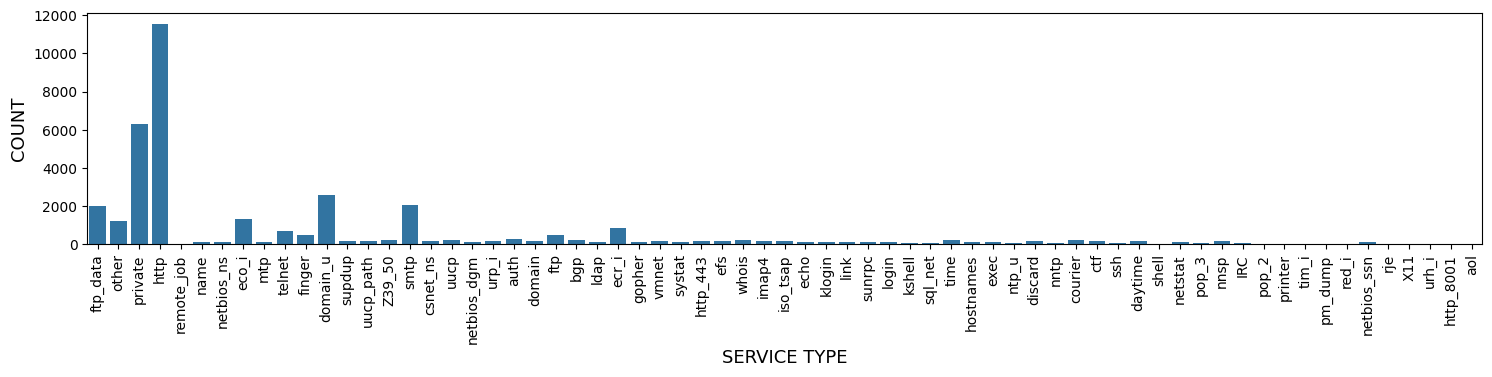

In [ ]:
# service distribution
plt.figure(figsize=(18,3))
sns.countplot(x="service", data=train)
plt.xlabel("SERVICE TYPE", fontsize=13)
plt.ylabel("COUNT", fontsize=13)
plt.xticks(rotation=90)
plt.show()

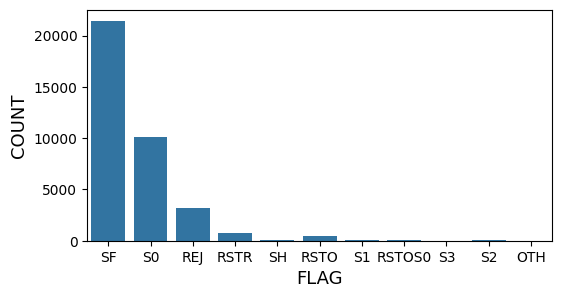

In [ ]:
# flag distribution
plt.figure(figsize=(6,3))
sns.countplot(x="flag", data=train)
plt.xlabel("FLAG", fontsize=13)
plt.ylabel("COUNT", fontsize=13)
plt.show()

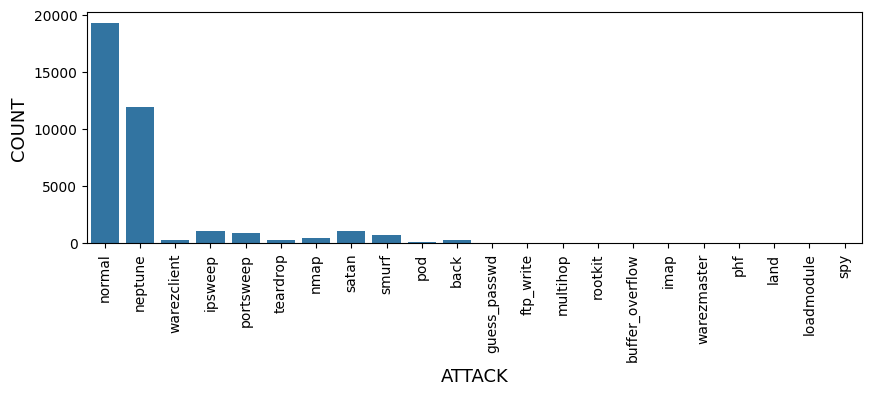

In [ ]:
# attack distribution
plt.figure(figsize=(10,3))
sns.countplot(x="attack", data=train)
plt.xlabel("ATTACK", fontsize=13)
plt.ylabel("COUNT", fontsize=13)
plt.xticks(rotation=90)
plt.show()

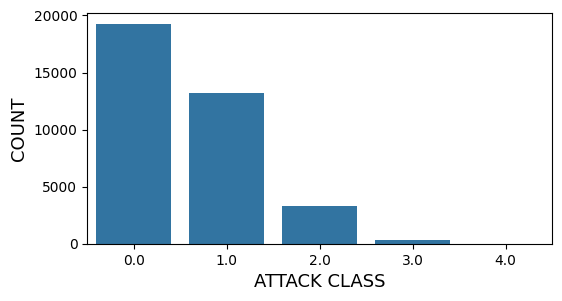

In [ ]:
# attack class distribution
plt.figure(figsize=(6,3))
sns.countplot(x="attack_class", data=train)
plt.xlabel("ATTACK CLASS", fontsize=13)
plt.ylabel("COUNT", fontsize=13)
plt.show()

In [ ]:
numeric_columns = train.select_dtypes(include=[float, int]).columns
train.groupby('attack_class')[numeric_columns].mean().T.drop("attack_class")

attack_class,0.0,1.0,2.0,3.0,4.0
duration,176.984591,0.006428,2201.211064,529.135922,104.400000
src_bytes,10523.825776,1179.929517,114774.940770,299768.961165,1228.666667
dst_bytes,4219.172979,169.496635,23.054420,121144.605178,5810.200000
land,0.000052,0.000151,0.000000,0.000000,0.000000
wrong_fragment,0.000000,0.062467,0.000000,0.000000,0.000000
urgent,0.000156,0.000000,0.000000,0.000000,0.066667
hot,0.232282,0.039704,0.002405,7.802589,1.666667
num_failed_logins,0.001349,0.000000,0.001203,0.042071,0.000000
logged_in,0.709401,0.021024,0.006013,0.909385,0.933333
num_compromised,0.383262,0.018906,0.001203,0.122977,1.866667


<Axes: >

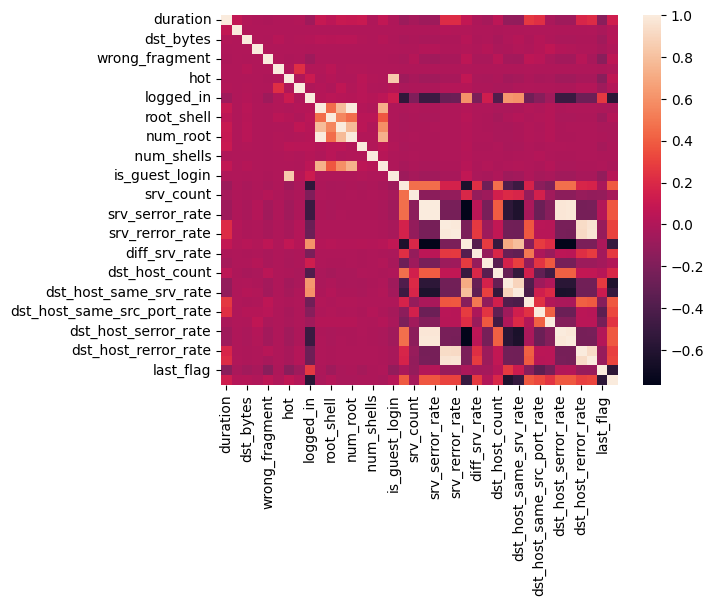

In [ ]:
train = train[[col for col in train if train[col].nunique() > 1]]
numeric_columns = train.select_dtypes(include=[float, int]).columns
correlation=train[numeric_columns].corr()
sns.heatmap(correlation)

<Axes: >

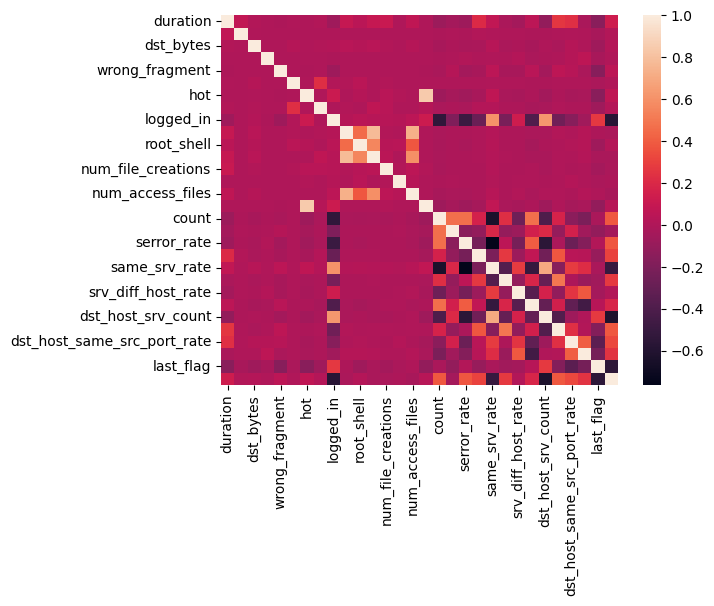

In [ ]:
# This variable is highly correlated with num_compromised and should be ignored for analysis.
#(Correlation = 0.9938277978738366)
train.drop('num_root', axis = 1, inplace = True)

# This variable is highly correlated with serror_rate and should be ignored for analysis.
#(Correlation = 0.9983615072725952)
train.drop('srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9947309539817937)
train.drop('srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
#(Correlation = 0.9993041091850098)
train.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9869947924956001)
train.drop('dst_host_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9821663427308375)
train.drop('dst_host_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9851995540751249)
train.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9865705438845669)
train.drop('dst_host_same_srv_rate', axis = 1, inplace = True)

train.drop('service', axis = 1, inplace = True)


numeric_columns = train.select_dtypes(include=[float, int]).columns
correlation=train[numeric_columns].corr()
sns.heatmap(correlation)

In [ ]:

# protocol_type feature mapping
pmap = {'icmp':0, 'tcp':1, 'udp':2}
train['protocol_type'] = train['protocol_type'].map(pmap)

# flag feature mapping
fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
train['flag'] = train['flag'].map(fmap)


# protocol_type feature mapping
pmap = {'icmp':0, 'tcp':1, 'udp':2}
test['protocol_type'] = test['protocol_type'].map(pmap)

# flag feature mapping
fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
test['flag'] = test['flag'].map(fmap)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36148 entries, 0 to 36147
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     36148 non-null  int64  
 1   protocol_type                36148 non-null  int64  
 2   flag                         36148 non-null  int64  
 3   src_bytes                    36148 non-null  int64  
 4   dst_bytes                    36148 non-null  int64  
 5   land                         36148 non-null  int64  
 6   wrong_fragment               36148 non-null  int64  
 7   urgent                       36148 non-null  int64  
 8   hot                          36148 non-null  int64  
 9   num_failed_logins            36148 non-null  int64  
 10  logged_in                    36148 non-null  int64  
 11  num_compromised              36148 non-null  int64  
 12  root_shell                   36148 non-null  int64  
 13  su_attempted    

In [ ]:
# X = train[train.columns.drop(['attack_class', 'attack'])]

# X_new = SelectKBest(f_classif, k=15).fit(X, train['attack_class'])
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Drop rows where 'attack_class' or any feature has NaN values
train_clean = train.dropna(subset=['attack_class'] + list(X.columns))

# Separate features and target
X_clean = train_clean[train.columns.drop(['attack_class', 'attack'])]

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_clean)

# Feature selection
X_new = SelectKBest(f_classif, k=15).fit(X_imputed, train_clean['attack_class'])



In [ ]:
X_new.get_support()

array([False, False,  True, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
KBest_features=X.columns[X_new.get_support()]
KBest_features

Index(['flag', 'logged_in', 'root_shell', 'count', 'serror_rate',
       'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'last_flag'],
      dtype='object')

In [ ]:
features=['flag', 'hot', 'logged_in', 'count', 'serror_rate', 'rerror_rate','same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate','dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate','last_flag']
X_train = train[features]
y_train = train['attack_class']
X_test = test[features]
y_test = test['attack_class']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

StandardScaler()

In [ ]:
# Now apply the transformations to the data:
train_X = scaler.transform(X_train)
test_X = scaler.transform(X_test)

In [ ]:
# mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
# mlp.fit(train_X,y_train)
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

# Ensure there are no missing values in train_X
imputer = SimpleImputer(strategy='mean')
train_X_imputed = imputer.fit_transform(train_X)

# Ensure there are no missing values in y_train
# Assuming y_train should not have any NaN values, if it does, handle appropriately
y_train_clean = y_train.dropna()  # or handle as appropriate

# If you drop NaNs in y_train, ensure corresponding rows in train_X are also removed
if len(y_train_clean) != len(y_train):
    train_X_imputed = train_X_imputed[y_train_clean.index]

In [ ]:
import numpy as np

class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        # init weights
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)




In [ ]:
    clf = SVM()
    clf.fit(X_train_imputed, y_train_clean)
    predictions = clf.predict(X_test)

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    print("SVM classification accuracy", accuracy(y_test, predictions))

    # def visualize_svm():
    #     def get_hyperplane_value(x, w, b, offset):
    #         return (-w[0] * x + b + offset) / w[1]

    #     fig = plt.figure()
    #     ax = fig.add_subplot(1, 1, 1)
    #     plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

    #     x0_1 = np.amin(X[:, 0])
    #     x0_2 = np.amax(X[:, 0])

    #     x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    #     x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    #     x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    #     x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    #     x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    #     x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    #     ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    #     ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    #     ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    #     x1_min = np.amin(X[:, 1])
    #     x1_max = np.amax(X[:, 1])
    #     ax.set_ylim([x1_min - 3, x1_max + 3])

    #     plt.show()

    # visualize_svm()

SVM classification accuracy 0.22972853087295955


In [ ]:


# Train the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(train_X_imputed, y_train_clean)


MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [ ]:
y_pred=mlp.predict(test_X)
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,y_pred))

[[9338   97  268    8    0]
 [1188 6011  110  151    0]
 [ 525  263 1628    5    0]
 [1445  447  684  307    2]
 [   1    4   20   39    3]]


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      9711
           1       0.88      0.81      0.84      7460
           2       0.60      0.67      0.63      2421
           3       0.60      0.11      0.18      2885
           4       0.60      0.04      0.08        67

    accuracy                           0.77     22544
   macro avg       0.69      0.52      0.52     22544
weighted avg       0.76      0.77      0.73     22544



In [ ]:
mlp.coefs_

[array([[-1.58655569e-01, -3.25872577e-01,  4.54172492e-02,
          1.28029170e-01,  3.49652585e-02,  1.66066522e-02,
         -2.35829658e-01, -1.79797104e-01,  9.93242299e-02,
         -3.61154552e-02, -1.72434058e-01,  1.52036962e-01,
          2.31093758e-01, -1.75236210e-01,  9.29048141e-02,
          3.52182915e-01,  5.91016557e-01,  1.62272734e-01,
         -3.57164373e-01, -5.91323527e-02, -2.69775279e-01,
         -6.19944096e-01,  2.75307000e-01, -6.84100075e-02,
          2.37628239e-01, -3.01413660e-01,  2.58684712e-01,
         -2.41313452e-01,  5.18680340e-02, -2.28963893e-01],
        [-7.59795363e-01,  1.00198456e-01, -8.13442844e-01,
          3.82982995e-02, -1.92022683e-01, -5.20111661e-01,
          3.78340040e-02, -8.69541351e-01,  4.08640395e-01,
          2.81501718e-02,  3.58944117e-01, -3.83402226e-01,
         -2.63053655e-01, -4.43297259e-01,  4.42244083e-01,
          1.28380327e-01,  1.28257428e-01,  2.21937235e-01,
          1.69972871e-01,  5.33165726e-

In [ ]:
accuracy_score( y_test, y_pred )

0.7668115684882896

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
# svm_clf = LinearSVC(random_state=0, tol=1e-5)
# svm_clf.fit(X_train, y_train)
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

# Impute missing values in X_train with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Ensure y_train does not contain NaN values
# If y_train contains NaNs, handle them appropriately, e.g., by dropping rows with NaNs in y_train
y_train_clean = y_train.dropna()

# Ensure the same rows are removed from X_train_imputed if y_train_clean is smaller than y_train
if len(y_train_clean) != len(y_train):
    X_train_imputed = X_train_imputed[y_train_clean.index]

# Train the LinearSVC
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train_imputed, y_train_clean)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [ ]:
y_pred=svm_clf.predict(X_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


array([1., 1., 0., ..., 3., 0., 2.])

In [ ]:
accuracy_score( y_test, y_pred )

0.7256476224272533

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

model = SVC(kernel='rbf', class_weight='balanced',gamma='scale')

In [ ]:
# model.fit(X_train, y_train)
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

# Assuming X_train and y_train are already defined
# Impute missing values in X_train with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Ensure y_train does not contain NaN values
# Dropping NaN values in y_train
y_train_clean = y_train.dropna()

# Ensure the same rows are removed from X_train_imputed if y_train_clean is smaller than y_train
if len(y_train_clean) != len(y_train):
    X_train_imputed = X_train_imputed[y_train_clean.index]

# Train the model, e.g., SVC
model = SVC()
model.fit(X_train_imputed, y_train_clean)


SVC()

In [ ]:
y_pred=model.predict(X_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([1., 1., 0., ..., 0., 0., 0.])

In [ ]:
accuracy_score( y_test, y_pred )

0.6613289567068843

In [ ]:
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_imputed, y_train_clean)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred=lr_clf.predict(X_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([1., 1., 0., ..., 0., 0., 1.])

In [ ]:
accuracy_score(y_test, y_pred)

0.6629701916252662

In [ ]:
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn import metrics
import sklearn.tree as dt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_tree = DecisionTreeClassifier( max_depth = 5)
clf_tree=clf_tree.fit( X_train_imputed, y_train_clean )

In [ ]:
# y_pred=qda.predict(X_test)
# y_pred

In [ ]:
param_grid = {'max_depth': np.arange(3, 9),
             'max_features': np.arange(3,9)}

In [ ]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( X_train_imputed, y_train_clean )

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8]),
                         'max_features': array([3, 4, 5, 6, 7, 8])})

In [ ]:
tree.best_score_

0.9832904964195427

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC


In [ ]:
seed = 7
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_train_imputed, y_train_clean, cv=kfold)
print(results.mean())





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9446705795274409


In [ ]:
ensemble.fit(X_train_imputed, y_train_clean)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('cart', DecisionTreeClassifier()),
                             ('svm', SVC())])

In [ ]:
y_pred=ensemble.predict(X_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([1., 1., 0., ..., 0., 0., 0.])

In [ ]:
accuracy_score( y_test, y_pred )

0.6763218594748048